# 5 - Speaker identification


Based on the colab notebook

https://colab.research.google.com/drive/1k3XQPChxUGKmkZyw9O0B4hOtU8JBKZcz?usp=sharing#scrollTo=ByBve3vJw2xV

## Setup

### Install deep-speaker

In [ ]:
%%capture
!git clone https://github.com/philipperemy/deep-speaker.git

%cd deep-speaker

In [ ]:
%%capture
! sudo apt-get install libsndfile-dev
! pip install -r requirements.txt

In [ ]:
import sys  
sys.path.insert(0, '/content/deep-speaker/deep_speaker/')

### Download pretrained models

In [ ]:
import os

# ResCNN Softmax+Triplet trainedモデル
!wget "https://drive.google.com/uc?export=download&id=1F9NvdrarWZNktdX9KlRYWWHDwRkip_aP" -O pretrained.h5

### Imports

In [88]:
import numpy as np
import librosa
from IPython.display import Audio
from google.colab import drive
import shutil
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Deep speaker imports
from audio import read_mfcc
from batcher import sample_from_mfcc
from constants import SAMPLE_RATE, NUM_FRAMES
from test import batch_cosine_similarity
from conv_models import DeepSpeakerModel


In [102]:
#@title Aux functions

def encode_wav(model, wav_fn):
    mfcc = sample_from_mfcc(read_mfcc(wav_fn, SAMPLE_RATE), NUM_FRAMES)
    emb = model.m.predict(np.expand_dims(mfcc, axis=0))
    return emb # 1 x 512

def similarity(emb1, emb2):
    sim = batch_cosine_similarity(emb1, emb2)[0]
    return sim

def display_audio(path):
  audio, sr = librosa.load(path)
  return Audio(audio, rate=sr, autoplay=True)

Initialize the model used in the embedding extraction

In [ ]:
model = DeepSpeakerModel()
model.m.load_weights("pretrained.h5", by_name=True)

## Load dataset


Mount drive

In [ ]:
drive.mount("/content/drive/")
shutil.copy('/content/drive/MyDrive/Máster/DLASP/Final/dataset_hifi.zip', 
            '/content/dataset.zip')

Extract dataset 

In [ ]:
dataset_folder = Path('/content/dataset/')
shutil.unpack_archive('/content/dataset.zip', dataset_folder)

Load metadata

In [ ]:
df = pd.read_csv(dataset_folder / "metadata.csv")
df.head()

,Unnamed: 0,text,filename,song
0,0,"Busco una calma inalcanzable, la atmósfera aq...",segment1.wav,53_nada_ni_nadie
1,1,"quiero estar solo, si solo todo estará bien",segment2.wav,53_nada_ni_nadie
2,2,"que nadie me hable, que no rompan este silenc...",segment3.wav,53_nada_ni_nadie
3,3,"hoy quiero sentir el frío, vértigo que el mun...",segment4.wav,53_nada_ni_nadie
4,4,"harto de fingir excusas, musa siento huir de ...",segment5.wav,53_nada_ni_nadie


Filter all segments with <=3 words (304 fragments in total)

In [ ]:
df_filtrado = df[df.text.str.split(" ").str.len() > 3].reset_index(drop=True).copy()

Compute embedding vectors for all the 

In [ ]:
embeddings = {}
for i, row in tqdm(df_filtrado.iterrows(), total=len(df_filtrado), leave=False):
  if row.filename not in embeddings:
    filename = dataset_folder / row.filename
    try:
      embedding = encode_wav(model, filename)
      embeddings[row.filename] = embedding
    except ValueError:
      print(f"Error in filename {filename}")

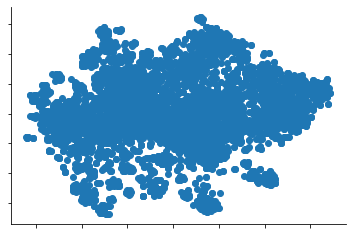

In [89]:
tsne = TSNE(init="random", learning_rate="auto")
X = np.concatenate(list(embeddings.values()))
projection = tsne.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(projection[:,0], projection[:, 1])
sns.despine(ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([]);

Remove the segments (only 5) too short to compute the embeddings

In [95]:
df_filtrado = df_filtrado[df_filtrado.filename.isin(list(embeddings.keys()))].copy()

## Choose reference segments

Inspect some samples randomly and verify that is Natch

In [199]:
references = [1, 2, 3, 4, 5, 6, 7, 8, 50, 51, 300, 301, 302, 303, 304, 305, 306,
              400, 401, 402, 500, 501, 502, 503, 504, 505,
              600, 750, 751, 752, 753, 754, 755, 800, 801, 802, 803,
              900,901, 902, 903, 904, 905, 1000, 1001,
              1100, 1101, 1102, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111,
              1400, 1401, 1402, 1403, 1404, 1405, 1800, 1801, 1802, 2000,
              2001, 2002, 2004, 2005, 2105, 4000, 4001, 4002, 4003, 4004,
              4005, 4006, 4007, 4008, 4009, 4010, 4700, 4701, 4900, 4901, 4902, 4903
              ]
negative = [120, 121, 605, 3000, 4500, 4600, 4601]

In [194]:
n = 4903
display_audio(dataset_folder / f"segment{n}.wav")

In [202]:
embeddings_files = list(embeddings.keys())
references_files = [f"segment{n}.wav" for n in references]
references_files = [r for r in references_files if r in embeddings_files]

86

Compute distance using cosine similarity

In [ ]:
distances = np.full((len(embeddings_files), len(references_files)), -1).astype(float)
for i, emb_i in enumerate(tqdm(embeddings_files, leave=False)):
  embi = embeddings[emb_i]
  for j, emb_j in enumerate(references_files):
    embj = embeddings[emb_j]
    distances[i, j] = similarity(embi, embj)

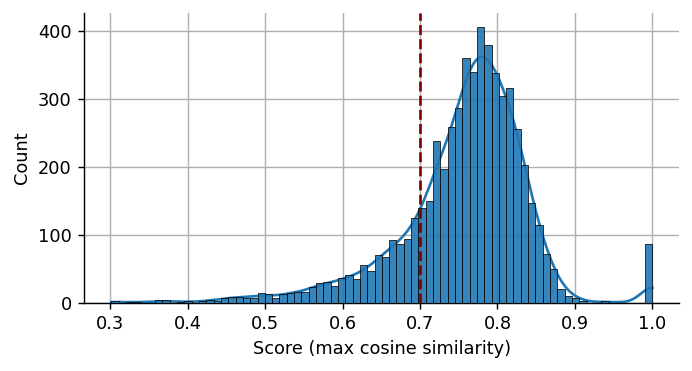

In [287]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=128)
sns.histplot(distances.max(axis=1), kde=True, ax=ax, alpha=0.9, zorder=30)
sns.despine(ax=ax)
ax.grid(True)
ax.set_xlabel('Score (max cosine similarity)')
ax.vlines(0.7, *ax.set_ylim(), color='maroon', ls='--', zorder=31);

Examples

*  0.3 -> 5140, 5691
* 0.35 -> 4516
* 0.4 -> 3737
* 0.45 -> 4165
* 0.5 -> 5361
* 0.55 -> 4853
* 0.6 -> 3708
* 0.65 -> 5922, 2715
* 0.7 -> 3633
* 0.75 -> 5421
* 0.8 -> 3152
* 0.9 -> 3050

In [242]:
distance_max = distances.max(axis=1)
df_distances = []
for emb, d in zip(embeddings_files, distance_max):
  df_distances.append({"segment": emb, "distance": d})
df_distances = pd.DataFrame(df_distances)

In [289]:
n = 3050
display_audio(dataset_folder / f"segment{n}.wav")

In [301]:
threshold = 0.7
segments_passed = df_distances[df_distances.distance>threshold].segment
df_final = df_filtrado[df_filtrado.filename.isin(segments_passed)].reset_index().copy()
df_final = df_final.drop(columns="Unnamed: 0")

# Create clean dataset

In [294]:
dataset_final_folder = Path("/content/dataset_clean/")
dataset_final_folder.mkdir(exist_ok=True)

In [302]:
df_final.to_csv(dataset_final_folder / "metadata.csv", index=False)

In [ ]:
for i, row in tqdm(df_final.iterrows(), total=len(df_final)):
  shutil.copy(dataset_folder / row.filename, dataset_final_folder / row.filename)

In [306]:
shutil.make_archive("dataset_clean", 'zip', dataset_final_folder)

'/content/deep-speaker/dataset_clean.zip'

In [307]:
shutil.copy("dataset_clean.zip", "/content/drive/MyDrive/Máster/DLASP/Final/dataset_clean.zip" )

'/content/drive/MyDrive/Máster/DLASP/Final/dataset_clean.zip'

In [309]:
df_distances.to_csv("/content/drive/MyDrive/Máster/DLASP/Final/verification_max_distances.csv" )